# Similarity of shape and electrostatic potential

In this notebook we show how to align molecules with a constrained core, and compute metrics of shape and electrostatic potential similarities.

Prerequisites: RDKit, py3Dmol and the small espsim package

In [172]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import py3Dmol
from ipywidgets import interact, interactive, fixed # For interactive display of conformers
from espsim import EmbedAlignConstrainedScore,ConstrainedEmbedMultipleConfs,GetEspSim

The functions drawOne() and drawTwo() draw 3D molecule conformations, so that we can have a look at them conveniently. The function drawMulti() will be used to plot multiple conformers in an interactive window. The only difference to drawOne is that it expects a py3Dmol.view object as input. The drawing functions were taken from http://rdkit.blogspot.com/2016/07/using-ipywidgets-and-py3dmol-to-browse.html

In [173]:
def drawTwo(m1, m2,p=None, confId1=-1, confId2=-1):
        if p is None:
            p = py3Dmol.view(width=400, height=400)
        p.removeAllModels()
        mb1=Chem.MolToMolBlock(m1, confId=confId1)
        p.addModel(mb1, 'sdf')
        mb2=Chem.MolToMolBlock(m2, confId=confId2)
        p.addModel(mb2, 'sdf')
        p.setStyle({'model':0},{'stick':{'colorscheme': 'purpleCarbon','radius':0.15}})
        p.setStyle({'model':1},{'stick':{'radius':0.15}})
        p.setBackgroundColor('white')#'0xeeeeee')
        p.zoomTo()
        return p.show()
def drawOne(m1, p=None, confId1=-1):
        if p is None:
            p = py3Dmol.view(width=400, height=400)
        p.removeAllModels()
        mb1=Chem.MolToMolBlock(m1, confId=confId1)
        p.addModel(mb1, 'sdf')
        p.setStyle({'model':0},{'stick':{'radius':0.15}})
        p.setBackgroundColor('white')#'0xeeeeee')
        p.zoomTo()
        return p.show()
def drawMulti(m1,p,confId=-1):
        mb1 = Chem.MolToMolBlock(m1,confId=confId)
        p.removeAllModels()
        p.addModel(mb1,'sdf')
        p.setStyle({'stick':{'radius':0.15}})
        p.setBackgroundColor('white')
        p.zoomTo()
        return p.show()

## Simple alignment and comparison:

In [174]:
refSmiles=['C1=CC=C(C=C1)C(C(=O)O)O','CCC(C(=O)O)O','OC(C(O)=O)c1ccc(Cl)cc1','C1=CC(=CC=C1C(C(=O)O)O)O','COc1ccc(cc1)C(O)C(O)=O','OC(C(O)=O)c1ccc(cc1)[N+]([O-])=O','CCCC(C(=O)O)O','CCC(C)C(C(=O)O)O','CC(C(=O)O)O']
prbSmile='C(C(C(=O)O)O)O'
refMols=[Chem.AddHs(Chem.MolFromSmiles(x)) for x in refSmiles]
prbMol=Chem.AddHs(Chem.MolFromSmiles(prbSmile))

Let's take a look at the probe molecule...

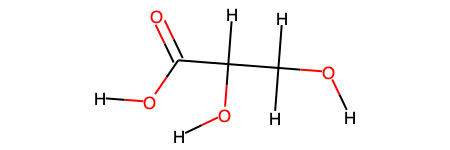

In [175]:
prbMol

... and the reference molecules:

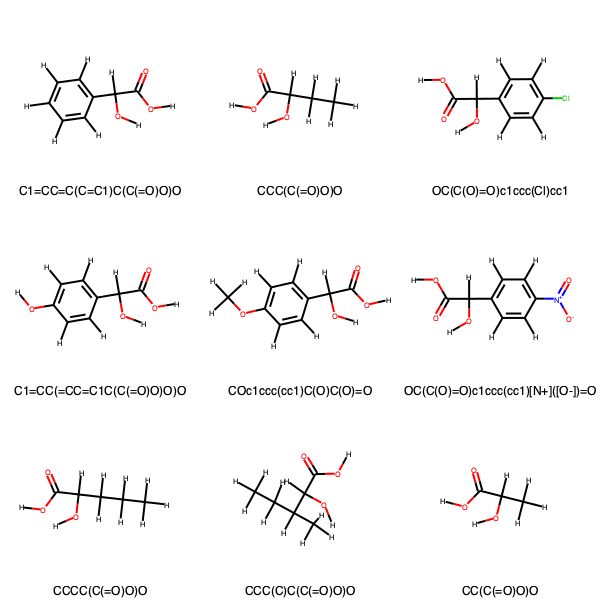

In [176]:
img=Draw.MolsToGridImage(refMols,molsPerRow=3,subImgSize=(200,200),legends=refSmiles)
img

The probe molecule and the reference molecule have all the same substructure:

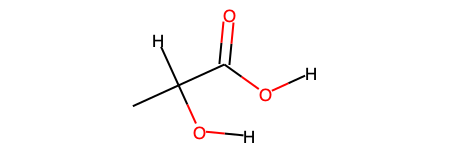

In [177]:
patt=Chem.MolFromSmiles("[H]OC([H])(C)C(=O)O[H]",sanitize=False)
patt

We could have obtained this substructure by a maximum-common-substructure search in RDKit, too, but you can also fill in any structure of interest manually as shown above.

To calculate the similarities of the probe molecule to the reference molecule, we start by creating 3D coordinates for the core. Since it is only a molecular fragment, not a full molecule, it is most convenient to create 3D coordinates from a helper molecule with Hs attached where there is a missing bond currently, but there are also other ways of creating coordinates, e.g via one of the reference molecules, and then cut away all atoms that do not match the pattern.

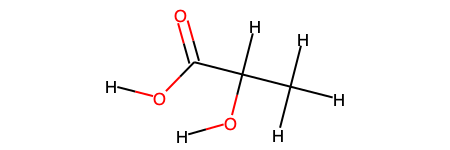

In [178]:
helper=Chem.AddHs(Chem.MolFromSmiles("[H]OC([H])(C)C(=O)O[H]"))
helper

In [179]:
AllChem.EmbedMolecule(helper,AllChem.ETKDG()) #Embed first reference molecule, create one conformer
AllChem.UFFOptimizeMolecule(helper) #Optimize the coordinates of the conformer
core = AllChem.DeleteSubstructs(AllChem.ReplaceSidechains(helper,patt),Chem.MolFromSmiles('*')) #Create core molecule with 3D coordinates
core.UpdatePropertyCache()

In [180]:
drawOne(core)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Now that we have a core with 3D coordinates, we can embed the probe and reference molecules with a constrained core, and calculate their similarities. With espsim, you can do this all in one function call: 

In [181]:
simShape,simEsp=EmbedAlignConstrainedScore(prbMol,refMols,core)

In [182]:
print('%35s %8s %8s' % ("Reference","Shape","ESP"))
for i in range(len(refSmiles)):
    print('%35s %8.2f %8.2f' % (refSmiles[i],simShape[i],simEsp[i]))

                          Reference    Shape      ESP
            C1=CC=C(C=C1)C(C(=O)O)O     0.65     0.89
                       CCC(C(=O)O)O     0.95     0.88
             OC(C(O)=O)c1ccc(Cl)cc1     0.57     0.89
           C1=CC(=CC=C1C(C(=O)O)O)O     0.60     0.74
             COc1ccc(cc1)C(O)C(O)=O     0.54     0.79
   OC(C(O)=O)c1ccc(cc1)[N+]([O-])=O     0.53     0.59
                      CCCC(C(=O)O)O     0.83     0.94
                   CCC(C)C(C(=O)O)O     0.73     0.92
                        CC(C(=O)O)O     0.89     0.87


We can also draw multiple conformers and click through them:

In [183]:
p = py3Dmol.view(width=400,height=400)
interact(drawMulti, m1=fixed(prbMol),p=fixed(p),confId=(0,prbMol.GetNumConformers()-1));

interactive(children=(IntSlider(value=0, description='confId', max=9), Output()), _dom_classes=('widget-intera…

The function EmbedAlignConstrainedScore() computes constrained embeddings of the probe and reference molecules with multiple conformers, searches for the best alignment, computes the shape similarity and the electrostatic similarity. Let us look into the code of the function:

In [184]:
def see_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

In [185]:
see_code(EmbedAlignConstrainedScore) #This magic function makes the source code appear, it is really convenient!

So, let us do something similar, and also plot the aligned molecules. Let's create ten conformers of the probe molecule and the first reference molecule:

In [187]:
prbMol=ConstrainedEmbedMultipleConfs(prbMol, core, numConfs=10)
refMol=ConstrainedEmbedMultipleConfs(refMols[0], core, numConfs=10)

In [188]:
p = py3Dmol.view(width=400,height=400)
interact(drawMulti, m1=fixed(prbMol),p=fixed(p),confId=(0,prbMol.GetNumConformers()-1));

interactive(children=(IntSlider(value=0, description='confId', max=9), Output()), _dom_classes=('widget-intera…

In [189]:
p = py3Dmol.view(width=400,height=400)
interact(drawMulti, m1=fixed(refMol),p=fixed(p),confId=(0,refMol.GetNumConformers()-1));

interactive(children=(IntSlider(value=0, description='confId', max=9), Output()), _dom_classes=('widget-intera…

If we plot some of the embeddings (first molecule with purble carbons, second with gray carbons), we see that part of the molecule (what corresponds to the core) has the same coordinates as the core RDKit molecule object, but the rest of the molecule can have different conformations:

In [190]:
drawTwo(prbMol,core,confId1=0)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [191]:
drawTwo(prbMol,core,confId1=1)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Drawing the probe molecule and the reference molecule yields the same picture: The core of both molecules should always overlap nicely:

In [192]:
drawTwo(prbMol,refMol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

espsim then goes on and aligns each conformer and looks for the pair of conformers of probe and reference that produces the best similarity in shape. Let us calculate a few similarities. The atom map in the alignment function call ensures that the core part of the molecules stay aligned.

In [193]:
prbMatch = prbMol.GetSubstructMatch(core)
refMatch = refMol.GetSubstructMatch(core)

In [194]:
AllChem.AlignMol(prbMol,refMol,atomMap=list(zip(prbMatch,refMatch)),prbCid=0,refCid=0)
1-AllChem.ShapeTanimotoDist(prbMol,refMol,confId1=0,confId2=0)

0.6328325393917186

In [195]:
AllChem.AlignMol(prbMol,refMol,atomMap=list(zip(prbMatch,refMatch)),prbCid=1,refCid=1)
1-AllChem.ShapeTanimotoDist(prbMol,refMol,confId1=1,confId2=1)

0.6037463976945245

Once we have found a good combination of conformers, e.g. the first for the probe molecule, and the second for the reference molecule, we can also compute the ESP similarity. In practice, espsim searches for the best volume alignment (lowest ShapeTanimotoDist) and computes the ESP similarity only on this combination of conformers.

In [196]:
AllChem.AlignMol(prbMol,refMol,atomMap=list(zip(prbMatch,refMatch)),prbCid=0,refCid=1)
GetEspSim(prbMol,refMol,0,1)

0.907380077563334

The ESP similarity is calculated via the overlap integrals of the electrostatic potentials of the two molecules. The electrostatic potential of a set of charges (here the partial charges of molecule A with N atoms) is defined as

\begin{equation*}
 \phi_A=\sum_{i=1}^N \frac{q_i}{|r-R_i|}
\end{equation*}

and the overlap integral between the electrostatic potentials of two molecules A and B as

\begin{equation*}
\int \phi_A \phi_B dV = \int \sum_{i=1}^N \sum_{j=1}^M \frac{q_i}{|r-R_i|} \frac{q_j}{|r-R_j|} dV
\end{equation*}

The 1/r function is difficult to integrate (usually integrated on a grid at points further away than the van-der Waals radii to avoid division through zero). A clever alternative is to approximate the function as a set of Gaussians:

\begin{equation*}
 \frac{1}{r} \simeq 0.3001e^{-0.0499r^2} + 0.9716*e^{-0.5026r^2} + 0.1268*e^{-0.0026r^2}
\end{equation*}

Utilizing this approximation, the overlap integral becomes the sum of N times M times 9 two-center integrals of Gaussians, which can be solved analytically:

\begin{equation*}
 \int e^{-\alpha_k|r-R_i|^2}e^{-\alpha_l|r-R_j|^2} = \left( \frac{\pi}{\alpha_k+\alpha_l} \right) ^ \frac{3}{2} * e^ \left( \frac{-\alpha_k\alpha_l}{\alpha_k+\alpha_l} | R_i - R_j| \right)
\end{equation*}

The overall similarity is then calculated according to the Carbo similarity:

\begin{equation*}
 S_{ESP}= \frac{\int \phi_A \phi_B dV }{\left(\int \phi_A \phi_A dV  \int \phi_B \phi_B dV \right)^\frac{1}{2} }
\end{equation*}

If you would like to learn more, contact Esther (eheid@mit.edu)